[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2025/figs_10_and_11_and_animations.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Arabas_et_al_2025/figs_10_and_11_and_animations.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2025/figs_10_and_11_and_animations.ipynb)

Figs 10 and 11 in [Arabas et al. 2025 (JAMES)](https://doi.org/10.1029/2024MS004770)

In [1]:
import os, sys
if sys.platform != 'darwin': # TODO #1749
    os.environ['NUMBA_THREADING_LAYER'] = 'omp'  # PySDM and PyMPDATA are incompatible with TBB threads
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
import string
import subprocess
import platform
import pathlib

import numpy as np

from scipy.io import netcdf_file
from scipy.ndimage import uniform_filter1d
from matplotlib import pyplot

from PySDM.exporters import NetCDFExporter, VTKExporter
from PySDM_examples.utils import ProgBarController
from open_atmos_jupyter_utils import show_plot
import PySDM.products as PySDM_products
from PySDM.physics import si
from PySDM import Formulae
from PySDM.initialisation import spectra
from PySDM.dynamics import Freezing

from PySDM_examples.Arabas_et_al_2015 import Settings
from PySDM_examples.utils.kinematic_2d import Simulation, Storage
from PySDM_examples.Arabas_et_al_2025.commons import FREEZING_CONSTANTS, LOGNORMAL_MODE_SURF_A, LOGNORMAL_SGM_G

## Simulations

In [3]:
lognormal_mode_A = LOGNORMAL_MODE_SURF_A
lognormal_sgm_g = LOGNORMAL_SGM_G
inp_frac = 1 / (270 + 45 + 1)

conc_cld_unit = '1/cc'
conc_ice_unit = '1/l'
cool_rate_unit = 'K/min'
wall_time_unit = 'ms'

N_REALISATIONS = 2

In [4]:
runs = (
    {'settings': {'rhod_w_max': 2.0 * si.m/si.s*si.kg/si.m**3, 'freezing_immersion': 'time-dependent'}},
    {'settings': {'rhod_w_max': 2.0 * si.m/si.s*si.kg/si.m**3, 'freezing_immersion': 'singular'}},
    {'settings': {'rhod_w_max': 1.0 * si.m/si.s*si.kg/si.m**3, 'freezing_immersion': 'time-dependent'}},
    {'settings': {'rhod_w_max': 1.0 * si.m/si.s*si.kg/si.m**3, 'freezing_immersion': 'singular'}},
    {'settings': {'rhod_w_max': 0.5 * si.m/si.s*si.kg/si.m**3, 'freezing_immersion': 'time-dependent'}},
    {'settings': {'rhod_w_max': 0.5 * si.m/si.s*si.kg/si.m**3, 'freezing_immersion': 'singular'}},
)
runs = tuple({'settings': {**run['settings'], 'seed': seed}} for run in runs for seed in range(N_REALISATIONS))

In [5]:
products = (
    PySDM_products.DynamicWallTime(
        'Condensation', name='Condensation_wall_time', unit=wall_time_unit
    ),
        PySDM_products.DynamicWallTime(
        'Displacement', name='Displacement_wall_time', unit=wall_time_unit
    ),
    PySDM_products.DynamicWallTime(
        'Freezing', name='Freezing_wall_time', unit=wall_time_unit
    ),
    PySDM_products.DynamicWallTime(
        'EulerianAdvection', name='EulerianAdvection_wall_time', unit=wall_time_unit
    ),
    PySDM_products.ParticleConcentration(
        radius_range=(-np.inf, 0*si.um), name='n_i', unit=conc_ice_unit, stp=True
    ),
    PySDM_products.ParticleConcentration(
        radius_range=(1*si.um, np.inf), name='n_c', unit=conc_cld_unit, stp=True
    ),
    PySDM_products.CoolingRate(
        unit=cool_rate_unit
    ),
    PySDM_products.IceNucleiConcentration(
        name='n_inp', unit=conc_ice_unit, stp=True
    ),
    PySDM_products.FrozenParticleConcentration(
        name='n_frozen_aerosols',
        unit=conc_ice_unit,
        count_activated=False,
        count_unactivated=True,
        stp=True
    ),
    PySDM_products.FrozenParticleConcentration(
        name='n_frozen_droplets',
        unit=conc_ice_unit,
        count_activated=True,
        count_unactivated=False,
        stp=True
    )
)

In [6]:
class SpinUp:
    """ enables freezing dynamic after a given number of steps """
    def __init__(self, particulator, spin_up_steps):
        self.spin_up_steps = spin_up_steps
        particulator.observers.append(self)
        self.particulator = particulator
        self.set(Freezing, "enable", False)

    def notify(self):
        if self.particulator.n_steps == self.spin_up_steps:
            self.set(Freezing, "enable", True)

    def set(self, dynamic, attr, val):
        name = dynamic.__name__
        if name in self.particulator.dynamics:
            setattr(self.particulator.dynamics[name], attr, val)

In [7]:
formulae = Formulae(
    particle_shape_and_density="MixedPhaseSpheres",
    freezing_temperature_spectrum='Niemand_et_al_2012',
    heterogeneous_ice_nucleation_rate='ABIFM',
    constants=FREEZING_CONSTANTS["dust"],
)

for i, run in enumerate(runs):
    folder = f"output/rhod_w_max={run['settings']['rhod_w_max']}_{run['settings']['freezing_immersion']}_seed={run['settings']['seed']}"
    os.makedirs(folder, exist_ok=True)
    
    run['ncfile'] = f'{folder}/out.nc'

    formulae.seed = run['settings']['seed']
    settings = Settings(formulae)
    settings.dt = 2.5 * si.s
    settings.output_interval = settings.dt * 12
    settings.simulation_time = 6000 * si.second if 'CI' not in os.environ else 2 * settings.output_interval
    settings.spin_up_time = 600 * si.second
    settings.size = (1500, 500)
    settings.n_sd_per_gridbox = 32
    settings.grid = (60, 20)
    settings.th_std0 -= 33.3 * si.kelvins
    settings.initial_water_vapour_mixing_ratio -= 6.66 * si.grams / si.kilogram
    
    settings.processes['coalescence'] = False
    settings.processes['sedimentation'] = False
    settings.processes['freezing'] = True
    settings.freezing_inp_spec = spectra.Lognormal(
        norm_factor=1,
        m_mode=lognormal_mode_A,
        s_geom=lognormal_sgm_g
    )
    settings.freezing_inp_frac = inp_frac
    settings.freezing_thaw = 'instantaneous'

    settings.kappa = 0.61
    settings.mode_1 = spectra.Lognormal(
        norm_factor=(270 + 270/315) / si.centimetre**3 / formulae.constants.rho_STP,
        m_mode=0.03 * si.micrometre,
        s_geom=1.28,
    )
    settings.mode_2 = spectra.Lognormal(
        norm_factor=(45 + 45/315) / si.centimetre**3 / formulae.constants.rho_STP,
        m_mode=0.14 * si.micrometre,
        s_geom=1.75,
    )
    settings.spectrum_per_mass_of_dry_air = spectra.Sum((settings.mode_1, settings.mode_2))
    
    for key, value in run['settings'].items():      
        if key != 'seed':
            assert hasattr(settings, key)
            setattr(settings, key, value)

    storage = Storage()
    simulation = Simulation(settings, storage, SpinUp=SpinUp)
    simulation.reinit(products)

    vtk_exporter = VTKExporter(path=folder)    
    simulation.run(ProgBarController(f"run {i+1}/{len(runs)}"), vtk_exporter=vtk_exporter)
    vtk_exporter.write_pvd()

    ncdf_exporter = NetCDFExporter(storage, settings, simulation, run['ncfile'])
    ncdf_exporter.run(ProgBarController('netCDF'))

FloatProgress(value=0.0, description='run 1/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 2/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 3/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 4/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 5/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 6/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 7/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 8/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 9/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 10/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 11/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 12/12', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

## Fig 11

In [8]:
def label(settings_arg):
    tmp = str({k.replace('condensation_', ''):
               f"{v:.1e}" if isinstance(v, float) else
               str(v).zfill(2) if isinstance(v, int) else
               v for k, v in settings_arg.items()})
    return tmp\
        .replace('{', '')\
        .replace('}', '')\
        .replace("'", '')\
        .replace('rhod_w_max:', '$w_{max}\\approx$')\
        .replace('e+00', r' m/s')\
        .replace('5.0e-01', '0.5 m/s')\
        .replace('freezing_immersion: ', '')\
        .replace('singular', r'singular$\,\,\,$')\
        .replace(', seed: 00', '')

$w_{max}\approx$ 0.5 m/s, singular$\,\,\,$, seed: 01: time=26.18ms
$w_{max}\approx$ 0.5 m/s, singular$\,\,\,$: time=26.88ms
$w_{max}\approx$ 0.5 m/s, time-dependent, seed: 01: time=26.69ms
$w_{max}\approx$ 0.5 m/s, time-dependent: time=27.07ms
$w_{max}\approx$ 1.0 m/s, singular$\,\,\,$, seed: 01: time=29.84ms
$w_{max}\approx$ 1.0 m/s, singular$\,\,\,$: time=29.95ms
$w_{max}\approx$ 1.0 m/s, time-dependent, seed: 01: time=30.41ms
$w_{max}\approx$ 1.0 m/s, time-dependent: time=30.15ms
$w_{max}\approx$ 2.0 m/s, singular$\,\,\,$, seed: 01: time=33.16ms
$w_{max}\approx$ 2.0 m/s, singular$\,\,\,$: time=32.70ms
$w_{max}\approx$ 2.0 m/s, time-dependent, seed: 01: time=32.16ms
$w_{max}\approx$ 2.0 m/s, time-dependent: time=34.79ms
$w_{max}\approx$ 0.5 m/s, singular$\,\,\,$, seed: 01: time=26.18ms
$w_{max}\approx$ 0.5 m/s, singular$\,\,\,$: time=26.88ms
$w_{max}\approx$ 0.5 m/s, time-dependent, seed: 01: time=26.69ms
$w_{max}\approx$ 0.5 m/s, time-dependent: time=27.07ms
$w_{max}\approx$ 1.0 m/s

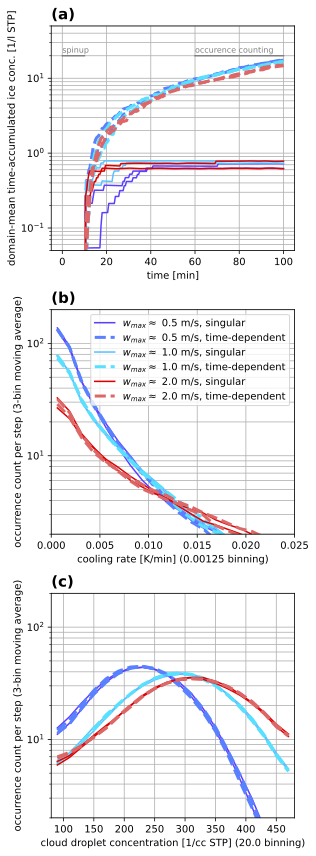

In [9]:
colors = (
    '#5940ff', '#5980ff', '#59c0ff', '#59e0ff', 
    '#dd0000', '#dd6666', '#dd9999', '#ddcccc', 
    '#777777', '#aaaaaa'
)
n_last_output_steps = 80 if 'CI' not in os.environ else 2
bins = {
    'n_i': 20,
    'cooling rate': 20,
    'n_c': 20,
    'n_inp': 20,
    #'n_frozen_aerosols': 12,
    #'n_frozen_droplets': 12
}
bin_range = {
    'n_i': None,
    'cooling rate': (0, .025),
    'n_c': (80, 480),
    #'n_inp': (400, 1600),
    #'n_frozen_aerosols': (5, 245),
    #'n_frozen_droplets': (5, 245)
}
window = 3

rows = 3
columns = 1

fig, axs = pyplot.subplots(rows, columns, sharey=False, tight_layout=True, figsize=(4.5, 12))
for plot_i, var in enumerate(bin_range.keys()):
    if len(axs.shape) == 2:
        ax = axs[plot_i//columns][plot_i%columns]
    else:
        ax = axs[plot_i]
    for i, run in enumerate(reversed(runs)):
        nc = netcdf_file(run['ncfile'], mode='r', mmap=False)
        n_spinup = nc.n_spin_up // nc.steps_per_output_interval
        data = nc.variables[var]
        timesteps = slice(-(n_last_output_steps+1), None)
        assert data.shape[0] >= n_last_output_steps

        style = {
            'color': colors[i % len(runs) // N_REALISATIONS], 
            'lw': 1.5 if run['settings']['freezing_immersion'] == 'singular' else 3,
            'ls': '--' if run['settings']['freezing_immersion'] != 'singular' else '-'
        }
        
        if var != 'n_i':
            wall_time = np.nanmean(nc.variables['Freezing_wall_time'][timesteps] / nc.steps_per_output_interval)
            wall_time = np.nan if not np.isfinite(wall_time) else int(100 * wall_time) / 100
            lbl = label(run['settings'])
            print(f"{lbl}: time={wall_time:.2f}{wall_time_unit}")      

            y, x, _ = ax.hist(
                data[timesteps, :, :].flatten(), 
                bins=bins[var],
                range=bin_range[var],
                histtype='step', 
                color=style['color'],
                lw=0
            )
            y /= n_last_output_steps
            filt_x = x[:-1] if window % 2 == 0 else (x[1:] + x[:-1])/2
            ax.plot(
                filt_x,
                uniform_filter1d(y, size=window),
                **style,
                label=f"{lbl}" if run['settings']['seed'] == 0 else ""
            )
            if i == 0:
                ax.set_yscale('log')
                ax.set_ylabel('occurrence count per step ' + f'({window}-bin moving average)')
                binwidth = (bin_range[var][1]-bin_range[var][0])/bins[var]
                ax.set_xlim(bin_range[var])
                ax.set_ylim(2, 200)
                if var == 'n_inp':
                    ax.set_xlabel(f'inclusion-rich (frozen or unfrozen) particle conc. [{conc_ice_unit} STP] ({binwidth} binning)')
                elif var == 'n_frozen_aerosols':
                    ax.set_ylim(.01, 100)
                    ax.set_xlabel(f'frozen aerosol concentration [{conc_ice_unit} STP] ({binwidth} binning)')
                elif var == 'n_frozen_droplets':
                    ax.set_ylim(.01, 100)
                    ax.set_xlabel(f'frozen droplet concentration [{conc_ice_unit} STP] ({binwidth} binning)')
                elif var == 'n_c':
                    ax.set_xlabel(f'cloud droplet concentration [{conc_cld_unit} STP] ({binwidth} binning)')
                elif var == 'cooling rate':
                    ax.set_xlabel(f'cooling rate [{cool_rate_unit}] ({binwidth} binning)')
                else:
                    assert False
        else:
            ax.plot(
                nc.variables['T'][:] / si.min,
                np.mean(np.mean(data[:,:,:], axis=1), axis=1) ,
                **style
            )
            if i == 0:
                ax.set_yscale('log')
                ax.set_ylim(.05, 50)
                ax.set_ylabel(f'domain-mean time-accumulated ice conc. [{conc_ice_unit} STP]')
                ax.set_xlabel('time [min]')
                for note, times in {
                    "spinup": [0, min(n_spinup, len(nc.variables['T'][:])-1)],
                    "occurence counting": [timesteps.start, -1]
                }.items():
                    x = nc.variables['T'][times] / si.min
                    y = 20
                    ax.plot(
                        x,
                        [y] * 2,
                        color='gray'
                    )
                    ax.text(x[0], 1.1 * y, note, color='gray', size=8)
                
    ax.grid(which='minor')
    ax.grid(which='major')
    if var == 'cooling rate':
        ax.legend(loc='upper right')
    ax.text(
        0, 1.03,
        '('+string.ascii_lowercase[plot_i]+')',
        transform=ax.transAxes,
        size=15,
        weight='bold'
    )
show_plot("figures.pdf")

## Fig 10 & animations

In [10]:
%%writefile pvscript.py

import argparse
import json
from paraview import simple as pvs

arg_parser = argparse.ArgumentParser()
arg_parser.add_argument('path')

arg_parser.add_argument('--particles_var')
arg_parser.add_argument('--particles_unit')
arg_parser.add_argument('--particles_color_range')
arg_parser.add_argument('--particles_var_multiplier', default=1)
arg_parser.add_argument('--particles_logscale', default=False)

arg_parser.add_argument('--surface_var')
arg_parser.add_argument('--surface_color_range')
arg_parser.add_argument('--surface_unit')

arg_parser.add_argument('--save_frame_pdfs', action=argparse.BooleanOptionalAction)
arg_parser.add_argument('--anim_path_suffix', default='')

args = arg_parser.parse_args()

# load data
reader_prod = pvs.OpenDataFile(f"{args.path}/output/sd_products.pvd")
reader_attr = pvs.OpenDataFile(f"{args.path}/output/sd_attributes.pvd")

# prepare view settings
view = pvs.GetRenderView()
view.ViewSize = [2000, 800]
view.Background = [1, 1, 1]
view.CenterAxesVisibility = False
view.OrientationAxesVisibility = False
axesGrid = view.AxesGrid
axesGrid.Visibility = True
axesGrid.XTitle = 'Z [$m$]'
axesGrid.YTitle = 'X [$m$]'

axesGrid.XAxisUseCustomLabels = True
axesGrid.XAxisLabels = [0, 125, 375, 500]
axesGrid.YAxisUseCustomLabels = True
axesGrid.YAxisLabels = [300, 600, 900, 1200]

axesGrid.XTitleFontSize = 30
axesGrid.XLabelFontSize = 30
axesGrid.YTitleFontSize = 30
axesGrid.YLabelFontSize = 30

axesGrid.XTitleColor = [0, 0, 0]
axesGrid.XLabelColor = [0, 0, 0]
axesGrid.YTitleColor = [0, 0, 0]
axesGrid.YLabelColor = [0, 0, 0]
axesGrid.GridColor = [0.1, 0.1, 0.1]

# render particles
if args.particles_var is not None:
    palette = 'Cold and Hot'
    palette_invert = True
    title = args.particles_var + r' [$' + args.particles_unit + '$]'
    
    calculator = pvs.Calculator(reader_attr)
    calculator.Function = f'{args.particles_var}*{args.particles_var_multiplier}'
    display_attr = pvs.Show(calculator, view)
    
    display_attr.SetRepresentationType('Point Gaussian')
    display_attr.ShaderPreset = 'Sphere'
    display_attr.GaussianRadius = 3
    display_attr.MapScalars = 1
    
    display_attr.Ambient = .25
    pvs.ColorBy(display_attr, ('POINTS', 'Result'))
    color_scale_attr = pvs.GetColorTransferFunction('Result')
    color_scale_attr.ApplyPreset(palette, True)
    if palette_invert:
        color_scale_attr.InvertTransferFunction()
    if args.particles_color_range is None:
        display_attr.RescaleTransferFunctionToDataRange(True)
    else:
        color_scale_attr.RescaleTransferFunction(json.loads(args.particles_color_range))
    if args.particles_logscale:
        color_scale_attr.MapControlPointsToLogSpace()
        color_scale_attr.UseLogScale = 1
    colorbar_attr = pvs.GetScalarBar(color_scale_attr, view)
    colorbar_attr.TitleColor = [0, 0, 0]
    colorbar_attr.LabelColor = [0, 0, 0]
    colorbar_attr.Title = title
    colorbar_attr.ComponentTitle = ''
    colorbar_attr.TitleFontSize = 30
    colorbar_attr.LabelFontSize = 30
    colorbar_attr.Visibility = True
    colorbar_attr.WindowLocation = 'Any Location'
    colorbar_attr.Position = [.025, .333]
    colorbar_attr.RangeLabelFormat = '%g'
    
# render product
if args.surface_var is not None:
    palette = 'X Ray'
    palette_invert = True
    color_range = [0, 300]
    logscale = False
    title = '$' + args.surface_var + '$' + ' [$' + args.surface_unit + '$ STP]'
    
    display_prod = pvs.Show(reader_prod)
    display_prod.SetRepresentationType('Surface')
    display_prod.Ambient = .25
    pvs.ColorBy(display_prod, ('CELLS', args.surface_var))
    color_scale_prod = pvs.GetColorTransferFunction(args.surface_var)
    if args.surface_color_range is None:
        display_prod.RescaleTransferFunctionToDataRange(True)
    else:
        color_scale_prod.RescaleTransferFunction(json.loads(args.surface_color_range))
    color_scale_prod.ApplyPreset(palette, True)
    if palette_invert:
        color_scale_prod.InvertTransferFunction()
    colorbar_prod = pvs.GetScalarBar(color_scale_prod, view)
    colorbar_prod.TitleColor = [0, 0, 0]
    colorbar_prod.LabelColor = [0, 0, 0]
    colorbar_prod.Title = title
    colorbar_prod.ComponentTitle = ''
    colorbar_prod.TitleFontSize = 30
    colorbar_prod.LabelFontSize = 30
    colorbar_prod.Visibility = True
    colorbar_prod.Position = [.925, .333]
    colorbar_prod.WindowLocation = 'Any Location'
    colorbar_prod.RangeLabelFormat = '%g'

# time annotation
time = pvs.AnnotateTimeFilter(guiName = "AnnotateTimeFilter1", Format = 'Time: %gs')
repr = pvs.Show(time, view)
repr.Color = [0.0, 0.0, 0.0]
repr.FontSize = 20
view.Update()

# compose the scene
scene = pvs.GetAnimationScene()
scene.UpdateAnimationUsingDataTimeSteps()
pvs.Render(view)
cam = pvs.GetActiveCamera()
cam.SetViewUp(1, 0, 0)
pos = list(cam.GetPosition())
pos[-1] = -pos[-1]
cam.SetPosition(pos)
cam.Dolly(1.85)

# save animation to an Ogg Vorbis file
anim_file = f'{args.path}/anim{args.anim_path_suffix}.ogv'
print(anim_file)
pvs.SaveAnimation(anim_file, view, FrameRate=5, Quality=0)

# save animation frame as pdfs
if args.save_frame_pdfs is not None:
    for t in reader_prod.TimestepValues:
        if t not in (0, 600, 1800, 6000):
            continue
        view.ViewTime = t
        for reader in (reader_prod, reader_attr):
            reader.UpdatePipeline(t)
        pvs.ExportView(
            filename=f'{args.path}/anim_frame_{t}{args.anim_path_suffix}.pdf',
            view=view,
            Rasterize3Dgeometry= False,
            GL2PSdepthsortmethod= 'BSP sorting (slow, best)',
        )

Writing pvscript.py


In [ ]:
if not ('CI' in os.environ and platform.system() == 'Windows'):
    for path in pathlib.Path('output').glob("*"):
        print(path)
        for args in (
            [path, '--anim_path_suffix=_cld', '--surface_var=n_c', '--surface_color_range=[0, 300]', '--particles_var=radius',         
                   '--particles_var_multiplier=1e6', '--particles_color_range=[0.5,10]', '--particles_logscale=True',    
                   r'--particles_unit=\mu m', f'--surface_unit={conc_cld_unit}',
                   '--save_frame_pdfs',
            ],
            [path, 
                '--anim_path_suffix=_ice',
                '--surface_var=n_i',
                '--surface_color_range=[0, 100]',
                f'--surface_unit={conc_ice_unit}',
                '--save_frame_pdfs',
            ] + (
                [
                    '--particles_var=freezing temperature',
                    '--particles_color_range=[225, 250]',
                    '--particles_unit=K',
                ] 
                if 'singular' in str(path) else 
                [
                    '--particles_var=immersed surface area',
                    '--particles_color_range=[0, 1]',
                    r'--particles_unit=\mu m^2',        
                    '--particles_var_multiplier=1e12',
                ]
            ),
        ):
            subprocess.run(
                ['pvpython', '--force-offscreen-rendering', 'pvscript.py'] + args,
                check=True,
            )